In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from scipy.integrate import quad

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
#import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
#from suntimes import SunTimes  
import sys
sys.path.append("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\optimisation_experiments")
from optimise_GDD_fctns import *
from nn_response_fctns import *

import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
C:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\optimisation_experiments\optimise_GDD_fctns.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [2]:
def split_ds_by_AEZ2(ds):
    ds_arid_low = ds.loc[ds['AEZ'].isin([1, 26, 29])].groupby(['Stations_id', 'year']).head(2)
    ds_humid_low = ds.loc[ds['AEZ'].isin([2, 3])].groupby(['Stations_id', 'year']).head(2)
    ds_arid_high = ds.loc[ds['AEZ'].isin([4, 10])].groupby(['Stations_id', 'year']).head(2)
    ds_humid_high = ds.loc[ds['AEZ'].isin([5, 11, 14])].groupby(['Stations_id', 'year']).head(2)
    ds_city = ds.loc[ds['AEZ'].isin([32])].groupby(['Stations_id', 'year']).head(2)
    print(f'\nnum arid low: {len(ds_arid_low)}',
        f'\nnum city: {len(ds_city)}',
        f'\nnum arid high: {len(ds_arid_high)}',
        f'\nnum humid low: {len(ds_humid_low)}',
        f'\nnum humid high: {len(ds_humid_high)}')
    ds_dict = {'arid low': ds_arid_low,
               'city': ds_city,
               'arid high': ds_arid_high,
               'humid low': ds_humid_low,
               'humid high': ds_humid_high}
    return ds_dict

In [3]:
def split_ds_by_AEZ5(ds):
    ds_semiarid_low = ds.loc[ds['AEZ'].isin([1])].groupby(['Stations_id', 'year']).head(2)
    ds_arid_low = ds.loc[ds['AEZ'].isin([26, 29])].groupby(['Stations_id', 'year']).head(2)
    ds_subhumid_low = ds.loc[ds['AEZ'].isin([2])].groupby(['Stations_id', 'year']).head(2)
    ds_humid_low = ds.loc[ds['AEZ'].isin([3])].groupby(['Stations_id', 'year']).head(2)
    ds_arid_high = ds.loc[ds['AEZ'].isin([4])].groupby(['Stations_id', 'year']).head(2)
    ds_humid_high = ds.loc[ds['AEZ'].isin([5])].groupby(['Stations_id', 'year']).head(2)
    ds_cool = ds.loc[ds['AEZ'].isin([10, 11, 14])].groupby(['Stations_id', 'year']).head(2)
    print(#f'\nnum cool: {len(ds_cool)}',
        f'\nnum semiarid low: {len(ds_semiarid_low)}',
        f'\nnum arid high: {len(ds_arid_high)}',
        f'\nnum humid low: {len(ds_humid_low)}',
        f'\nnum subhumid low: {len(ds_subhumid_low)}',
        f'\nnum subhumid high: {len(ds_humid_high)}')
    ds_dict = {#'cool': ds_cool,
               'semiarid low': ds_semiarid_low,
               'arid high': ds_arid_high,
               'humid low': ds_humid_low,
               'subhumid low': ds_subhumid_low,
               'humid high': ds_humid_high}
    return ds_dict

In [4]:
def local_opt(x1s, train, test, error_fctn = run_GDD_and_get_RMSE, lower_bounds = [0.05, 4, 20, 20, 35], upper_bounds = [1, 12, 35, 35, 60], #ds
              great_threshold = 13, response_type = 'Trapezoid', phase_list = ['yellow ripeness'],
              method = 'trust-constr', modified_cost = False, thresholds = [100], growing_period_length = 185,
              maxiter = 50, split = True, CCNN_split = False, test_size = 0.5, random_state=1, itr = 0.5, bias_term = False):
    #if split:
    #    train, test = train_test_split(ds, test_size=test_size, random_state = random_state)
    #    #train_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_training.csv')
    #elif CCNN_split:
    #    test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_results.csv')
    #    train_indices = train_indices.rename(columns = {'year': 'Referenzjahr'})
    #    test_indices = test_indices.rename(columns = {'year': 'Referenzjahr'})
    #    test = pd.merge(ds, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #    complement_indices = ds.index.difference(test.index)
    #
    #    # Filter df2 to keep only the rows with the complement indices
    #    train = ds.loc[complement_indices]
    #    #train = pd.merge(ds, train_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #    test = pd.merge(ds, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #else:
    #    train = ds
    #    test = ds
    only_phase = phase_list[0]
    if response_type == 'Trapezoid':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2],
                                                x[4] - x[3]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0, 0],
                                                [0, 0, -1, 1, 0],
                                                [0, 0, 0, -1, 1]])}
        constraints = scipy.optimize.LinearConstraint([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0], [0, 0, 0, -1, -1]], [0, 0, 0], [np.inf, np.inf, np.inf])
    elif response_type == 'Wang' or response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        if bias_term:
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0]]),lb= [0, 0], ub=[1000, 1000])
        else:  
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0], [0, 0, -1, 1]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0, 0], [0, 0, -1, 1, 0, 0]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Spline':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2],
                                                x[3]]),
                    'jac' : lambda x: np.array([[0 for count in range(20)],
                                                [0 for count in range(20)]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0 for count in range(20)], [0 for count in range(20)]]),lb= [-1, -1], ub=[1000, 1000])
    elif response_type == 'multi_phase':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2],
                                                x[6] - x[5],
                                                x[7] - x[6]]
                                                ),
                    'jac' : lambda x: np.array([[0, -1, 1, 0, 0, -1, 1, 0],
                                                [0, 0, -1, 1, 0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        if bias_term:
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0]]),lb= [0, 0], ub=[1000, 1000])
        else:  
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0], [0, 0, -1, 1]]),lb= [0, 0], ub=[1000, 1000])
    bounds = scipy.optimize.Bounds(lb=lower_bounds, ub = upper_bounds)
    x0 = np.array([1, 4, 25, 35, 45])
    final_mins = []
    for x0 in x1s:
        if method == 'trust-constr':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list, 
                                                                         new_unfinished_penalisation=modified_cost, 
                                                                         growing_period_length = growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'trust-constr',#'COBYQA',
                                    #jac='3-point',#
                                    jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', #jac='3-point',#[x0/1000 for x0 in 
                                                                                response_type = response_type, 
                                                                                phase_list = phase_list, 
                                                                                growing_period_length=growing_period_length,
                                                                                thresholds = thresholds),#
                                    constraints=[constraints],
                                    options={'verbose': 1, 'initial_tr_radius': itr, 'xtol':1e-7, 'maxiter':maxiter},# ,'gtol':1e-7, 'finite_diff_rel_step': 0.05
                                    bounds=bounds, tol=1e-9)
        elif method == 'SLSQP':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'SLSQP',
                                    #jac = '3-point',
                                    jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                                                                response_type = response_type, 
                                                                                phase_list = phase_list, 
                                                                                growing_period_length=growing_period_length,
                                                                                thresholds = thresholds),#jac='3-point',#
                                    constraints=[ineq_cons],
                                    options={'disp': 3, 'maxiter':maxiter, 'ftol': 1e-16},
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Nelder-Mead':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Nelder-Mead',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Powell':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Powell',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)
        print(x0, res.x, x0 - res.x)
        RMSE = error_fctn(res.x, test, 't2m', response_type = response_type, phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length)
        #print('R^2: ', r2_score(c_array[f'observed time to {only_phase}'], c_array[f'modelled time to {only_phase}']))
        print('RMSE at opt on test set: ', RMSE)
        print('R^2:', 1 - (RMSE**2/(test[f'observed time to {only_phase}'].var()*((len(test) - 1)/len(test)))))
        final_mins.append(res.x)
    return final_mins, res, train, test

In [5]:
def split_ds_by_AEZ2(ds):
    ds_arid_low = ds.loc[ds['AEZ'].isin([1, 26, 29])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_humid_low = ds.loc[ds['AEZ'].isin([2, 3])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_arid_high = ds.loc[ds['AEZ'].isin([4, 10])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_humid_high = ds.loc[ds['AEZ'].isin([5, 11, 14])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_city = ds.loc[ds['AEZ'].isin([32])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    print(f'\nnum arid low: {len(ds_arid_low)}',
        f'\nnum city: {len(ds_city)}',
        f'\nnum arid high: {len(ds_arid_high)}',
        f'\nnum humid low: {len(ds_humid_low)}',
        f'\nnum humid high: {len(ds_humid_high)}')
    ds_dict = {'arid low': ds_arid_low,
               'city': ds_city,
               'arid high': ds_arid_high,
               'humid low': ds_humid_low,
               'humid high': ds_humid_high}
    return ds_dict

In [ ]:
def K_fold_crossval(k_folds, input_dataset, model_class, 
                    epochs, bs, model_args, savename_prefix = 'KFold', 
                    freeze_params = False, loss = 'NLL', 
                    CNN=False, bce=False, lr = 0.01, MMD=False, 
                    n_channels = 4, DTF = False, obs_method = False, 
                    custom_loss = None, year_split = False, 
                    year_folds = [], GDD_init = None,
                    index_cols = ['Stations_id', 'year', 'Management', 'vargroup']):
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    #index_cols = ['Stations_id', 'year', 'Management', 'vargroup']#['year', 'Stations_id']
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    # Loop through each fold
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    loss_values = []
    R2s = []
    Biases = []
    Variances = []
    obsvars = []

    RMSEs = []
    SSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    lengths = []
    if year_split:
        splitter = year_folds
    else:
        statyear = input_dataset[index_cols].drop_duplicates()
        splitter = kf.split(statyear)
    for fold, traintest_idx in enumerate(splitter):
        print(f"Fold {fold + 1}")
        if year_split:
            X_tensor, y_tensor = train_ds
            train_dl, val_dl = train_test_dl_by_year(X_tensor, y_tensor, test_years = traintest_idx, year_column = -2, bs = bs, n_channels = 8)
        # Define the data loaders for the current fold
        else:
            train_idx, test_idx = traintest_idx
            train_statyear = statyear.iloc[train_idx]
            test_statyear = statyear.iloc[test_idx]
            train = input_dataset.merge(train_statyear, on=index_cols, how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
            test = input_dataset.merge(test_statyear, on=index_cols, how = 'inner')
            lengths.append(len(test))
            X_tensor_train, y_tensor_train = ML_tensor_from_ds(train)
            X_tensor_test, y_tensor_test = ML_tensor_from_ds(test)
            #print(len(ds), X_tensor_test.shape, X_tensor_train.shape)
            train_ds, ___ = train_test_ds_from_tensors(X_tensor_train, y_tensor_train, train_proportion=1)
            val_ds, ___ = train_test_ds_from_tensors(X_tensor_test, y_tensor_test, train_proportion=1)
            train_dl = DataLoader(
                dataset=train_ds,
                batch_size=bs,
            )
            val_dl = DataLoader(
                dataset=val_ds,
                batch_size=bs,
            )
        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        if GDD_init is not None:
            if GDD_init == 'calculate':
                x1s = [np.array([0.5, 8, 23, 39])]
                fm = local_opt(x1s, train, test,
                            lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                            great_threshold = 13, response_type = 'Wang',
                            phase_list = ['beginning of flowering'],
                            method='Nelder-Mead',
                            thresholds = [20], growing_period_length=170,
                            test_size = 0.02, maxiter=200)
                GDD_params = fm[0][0]
                print(GDD_params)
                model = initialise_as_GDD(model, *GDD_params, n_channels=5)
            else:
                GDD_params = GDD_init[fold]#[0.31621224, 7.37066436, 22.88481424, 39.40562477]
                print(GDD_params)
                model = initialise_as_GDD(model, *GDD_params, n_channels=5)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss()
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False

        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce, verbose=True)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])
        comparison_frame = get_comparison_frame(savename_prefix + str(fold + 1), TS_model, val_dl, bce=bce, CNN=CNN, MMD=MMD, n_channels = n_channels, DTF = DTF, obs_method = obs_method)
        comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']

        bias_model = 0#comparison_frame['Error'].mean()
        RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
        SSE = np.sum((comparison_frame['Error'] - bias_model)**2)
        STD = comparison_frame['fitted'].std() 
        Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

        RMSEs.append(RMSE)
        SSEs.append(SSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_frame['Error'].min())
        LQs.append(comparison_frame['Error'].quantile(0.25))
        Medians.append(comparison_frame['Error'].median())
        UQs.append(comparison_frame['Error'].quantile(0.75))
        Maxs.append(comparison_frame['Error'].max())

        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        variance_observed = comparison_frame['observed'].var()
        
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)
        obsvars.append(variance_observed)

        if fold == 0:
            comparison_frame_full = comparison_frame
        else:
            comparison_frame_full = pd.concat((comparison_frame, comparison_frame_full))

    return comparison_frame_full, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars

In [7]:
def K_fold_transfer(k_folds, ds, model_class, 
                    savename, epochs, bs, model_args, 
                    lr = 0.01, savename_prefix = 'KFold',
                    loss = 'NLL', 
                    CNN=False, bce=False, custom_loss = None, 
                    MMD = False, DTF = False, obs_method = False,
                    transfer_method = 'all wang', verbose = False,
                    index_cols = ['Stations_id', 'year', 'Management', 'vargroup']):
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    # Loop through each fold
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_values = []
    R2s = []
    Biases = []
    Variances = []
    obsvars = []

    RMSEs = []
    SSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    lengths = []
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    statyear = ds[index_cols].drop_duplicates()
    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=index_cols, how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=index_cols, how = 'inner')
        lengths.append(len(test))
        #print(f"Fold {fold + 1}")
        X_tensor_train, y_tensor_train = ML_tensor_from_ds(train)
        X_tensor_test, y_tensor_test = ML_tensor_from_ds(test)
        #print(len(ds), X_tensor_test.shape, X_tensor_train.shape)
        train_ds, ___ = train_test_ds_from_tensors(X_tensor_train, y_tensor_train, train_proportion=1)
        val_ds, ___ = train_test_ds_from_tensors(X_tensor_test, y_tensor_test, train_proportion=1)
        # Define the data loaders for the current fold
        train_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
        )
        val_dl = DataLoader(
            dataset=val_ds,
            batch_size=bs,
        )
        model = model_class(*model_args).to(device)
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        for param in model.parameters():
            param.requires_grad = False
        if transfer_method == 'all wang':
            for param in [model.u0, model.u1, model.u2, model.u3]:
                param.requires_grad = True
        elif transfer_method == 'just rate':
            for param in [model.u4]:
                param.requires_grad = True
        elif transfer_method == 'wang and first':
            for param in [param for param in model.input_layer.parameters()] + [model.u0, model.u1, model.u2, model.u3]:
                param.requires_grad = True
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss
        # Train the model on the current fold

        #for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
        #    print(param.requires_grad, param.shape)
        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce, plot_opt=False, verbose=verbose)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])
        # Now convert to days and get R^2 to compare to other models
        list_logs = []
        list_GDD_logs = []
        list_observed = []
        for xb, yb in val_dl:
            with torch.no_grad():
                if CNN:
                    if MMD:
                        list_logs.append(TS_model(xb)[0])
                        list_GDD_logs.append(TS_model(xb, no_nn=True)[0])
                    else:
                        list_logs.append(TS_model(xb))
                        list_GDD_logs.append(TS_model(xb, no_nn=True))
                else:
                    list_logs.append(TS_model(xb.transpose(1, 2)))
                    list_GDD_logs.append(TS_model(xb.transpose(1, 2), no_nn=True))
                #print(TS_model(xb.transpose(1, 2)))
            list_observed.append(yb)
        logs = torch.squeeze(torch.cat(list_logs))
        GDD_logs = torch.squeeze(torch.cat(list_GDD_logs))
        observed = torch.cat(list_observed)
        #print(logs.shape, torch.cat(list_logs, dim=0).shape)
        if not(DTF):
            if bce:
                fitted = torch.round(logs)
                fitted_GDD = torch.round(GDD_logs)
            else:
                fitted = torch.argmax(logs, dim=2)
                fitted_GDD = torch.argmax(GDD_logs, dim=2)
        if DTF:
            logs = torch.round(logs)
            observed_days = mindex_at_0(observed)
            observed_days = observed[:, 0]
            observed_days = 90 + 100 - observed[:, 90]
            if obs_method:
                fitted_days = observed_days + logs[range(0, logs.shape[0]), observed_days.int()]
            else:
                fitted_days = mindex_at_0(logs)
                fitted_days = 90 + 100 - logs[:, 90]
                #fitted_days = logs[:, 90]
            #print(torch.sum(fitted_days < 30), ' fits too small')
        else:
            #print(len(fitted.shape))
            if len(fitted.shape) == 1:
                L = fitted.shape[0]
                fitted_days = L - fitted.sum()
                observed_days = L - observed.sum()
                GDD_days = L - fitted_GDD.sum()
            else:
                L = fitted.shape[1]
                fitted_days = L - fitted.sum(dim=1)
                observed_days = L - observed.sum(dim=1)
                GDD_days = L - fitted_GDD.sum(dim=1)
        if len(fitted.shape) > 1:
            comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze(), 'GDD fitted': GDD_days.numpy().squeeze()})
        else:
            comparison_frame = pd.DataFrame({'fitted': [fitted_days.numpy().squeeze()], 'observed': [observed_days.numpy().squeeze()], 'GDD fitted': [GDD_days.numpy().squeeze()]})
        comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']
        T_min = (9 + 10*(torch.tanh(TS_model.u1)) - 4).detach().cpu().numpy() #normally multiplier = 2
        T_opt = (28 + 7*(torch.tanh(TS_model.u2)) - 4).detach().cpu().numpy() #normally multiplier = 3
        T_max = (39 + 3.5*torch.tanh(TS_model.u3)).detach().cpu().numpy()#normally no multiplier
        scale = TS_model.u4.detach().cpu().numpy()
        threshold = TS_model.u0.detach().cpu().numpy()[0]
        x=[scale[0], T_min[0], T_opt[0], T_max[0]]
        #print(x, threshold)
        #print(test.columns.to_list())
        #cf2 = run_GDD(x, test.rename(columns={'Referenzjahr': 'year'}), 't2m', response_type='Wang', thresholds =[threshold], growing_period_length = 120)
        #print(cf2['modelled time to beginning of flowering'])
        #comparison_frame['GDD_fitted'] = cf2['modelled time to beginning of flowering'].values
        bias_model = 0#comparison_frame['Error'].mean()
        RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
        SSE = np.sum((comparison_frame['Error'] - bias_model)**2)
        STD = comparison_frame['fitted'].std() 
        Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

        RMSEs.append(RMSE)
        SSEs.append(SSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_frame['Error'].min())
        LQs.append(comparison_frame['Error'].quantile(0.25))
        Medians.append(comparison_frame['Error'].median())
        UQs.append(comparison_frame['Error'].quantile(0.75))
        Maxs.append(comparison_frame['Error'].max())

        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        variance_observed = comparison_frame['observed'].var()
        
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)
        obsvars.append(variance_observed)
        if fold == 0:
            comparison_frame_full = comparison_frame
        else:
            comparison_frame_full = pd.concat((comparison_frame, comparison_frame_full))

    return comparison_frame_full, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars


In [8]:
def K_fold_transfer_regions(ds_dict, transfer_method = 'just rate', index_cols = ['Stations_id', 'year', 'Management', 'vargroup']):
    bs = 30000
    n_channels = 5
    input_dim = n_channels # Example: 100-dimensional word embeddings
    hidden_dim = 16#day5 -> 16 day2 -> 8#day -> 16 #day3 ->4
    num_layers = 4#day3 -> 8
    output_dim = 1  # Example: 5 classes
    KG = False
    KG2 = True
    CNN = False
    bce=True

    model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, KG2)
    save_name = 'NN_response_DE_no_day5_more_epochs'#'NN_response_DE_no_day5'
    lr = 0.01
    epochs = 500
    # initialise lists for storing
    SSE_all_reg = []
    length_all_reg = []
    obsvars_all_reg = []
    regs = []
    comparison_frames = []
    for region in ds_dict.keys():
        #get data for specific region
        ds = ds_dict[region]
        if len(ds) < 10:
            continue
        regs.append(region)
        #convert to pytorch format
        #X_tensor, y_tensor = ML_tensor_from_ds(ds)
        #train_ds, val_ds = train_test_ds_from_tensors(X_tensor, y_tensor, train_proportion=1)
        #run K-fold cross validation
        criterion = problist_square_loss()
        comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_transfer(5, ds, nn_temp_response, 
                                                                                                                save_name, epochs, bs, model_args,lr = lr, 
                                                                                                                loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                                custom_loss=criterion, DTF = False, 
                                                                                                                transfer_method=transfer_method,
                                                                                                                index_cols = index_cols)
        comparison_frames.append(comparison_frame)
        print(region, R2s)
        #Store sum of squared errors, variance of obs and length of folds for evaluation
        SSE_all_reg.append(SSEs)
        length_all_reg.append(lengths)
        obsvars_all_reg.append(obsvars)
    results_dict = {'SSEs': SSE_all_reg,
                    'observed variances': obsvars_all_reg,
                    'fold lengths': length_all_reg,
                    'regions': regs,
                    'comparison_frames': comparison_frames}
    return results_dict

In [44]:
bs = 30000
n_channels = 5
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 2#16#day2 -> 8#day -> 16 #day3 ->4
num_layers = 2#4#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False
KG2 = True
CNN = False
bce=True

model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, KG2)

epochs = 5000
lr=0.025
#run K-fold cross validation
criterion = problist_square_loss()
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}
comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_crossval(5, combined_variety_tests_dict['arid low'], nn_temp_response, 
                                                                                                        epochs, bs, model_args, lr = lr, 
                                                                                                        loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                        custom_loss=problist_square_loss, DTF = False,
                                                                                                        GDD_init = None)#'calculate')

Fold 1
0 4237.54736328125 4575.09814453125
1 4586.4609375 4502.6005859375
2 4473.53662109375 3610.16796875
3 3384.16796875 4076.482177734375
4 4141.33984375 4386.70751953125
5 4401.826171875 4315.2685546875
6 4330.53125 3939.062744140625
7 3941.1494140625 3417.690185546875
8 3215.94677734375 4371.10888671875
9 4316.03564453125 4713.2197265625
10 4675.70751953125 4766.15576171875
11 4732.2998046875 4690.521484375
12 4651.83935546875 4405.884765625
13 4353.02001953125 3769.394775390625
14 3453.556884765625 3607.999267578125
15 3523.277587890625 4062.916015625
16 4004.73974609375 4210.32373046875
17 4132.68896484375 4120.6484375
18 4047.1875 3790.109130859375
19 3722.71337890625 3207.539306640625
20 3057.9814453125 3676.797119140625
21 3603.519775390625 4335.6142578125
22 4277.30078125 4443.21826171875
23 4391.1953125 4336.87744140625
24 4278.47900390625 3859.74072265625
25 3776.070068359375 2840.3056640625
475 2679.48046875 2875.458251953125
476 2061.693115234375 3331.478515625
477 2653.

KeyboardInterrupt: 

In [39]:
R2s

[-3.5827274322509766,
 -6.212426662445068,
 -2.4656081199645996,
 -33.16938781738281,
 -6.974588871002197]

In [22]:
skip = 1
numsteps = int(163 // skip)
#ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024_full.csv')
#ds_inputs_DE1[[f't2max at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE1[[f't2min at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')

#ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], axis = 0)
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_full.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 40]
new_series = []
ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    #if variable_name != 't2m' and variable_name != 'photoperiod':
    #    scaler = StandardScaler()
    #    scaler.fit(data)
    #    data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'].values for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

#NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype(int).values).unsqueeze(1)
#NDVI_labels_DE = 100 - torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

27153
27153


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_6308\356867199.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_34s6o8i12c\croot\libtorch_1751464457133\work\torch\csrc\utils\tensor_new.cpp:257.)
  year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T


In [9]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 105]
#ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] > 20]
ds_sites_AEZ2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\EIL_site_latlon_with_AEZ_filled.csv')
ds_inputs_SSA = ds_inputs_SSA.merge(ds_sites_AEZ2.rename(columns = {'LocationID': 'Stations_id'})[['Stations_id', 'AEZ2']], on='Stations_id', how='left')
ds_inputs_SSA['AEZ'] = ds_inputs_SSA['AEZ2']
ds_inputs_SSA = ds_inputs_SSA.rename(columns={'Referenzjahr': 'year'})
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['lat'] > -25]
#ds_vpd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_SSA_vpd_varieties_fixed.csv')
#ds_inputs_SSA = ds_inputs_SSA.drop(columns=[f'vpd at day {n}' for n in range(200)])
#ds_inputs_SSA = ds_inputs_SSA.merge(ds_vpd.drop(columns = ['Unnamed: 0', 'WC SOS date', 'observed time to beginning of flowering']), on = ['Stations_id', 'lat', 'lon', 'Management', 'vargroup', 'Referenzjahr'])
#ds_inputs_SSA = ds_inputs_SSA.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])
#ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_full.csv')
#ds_inputs_SSA.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

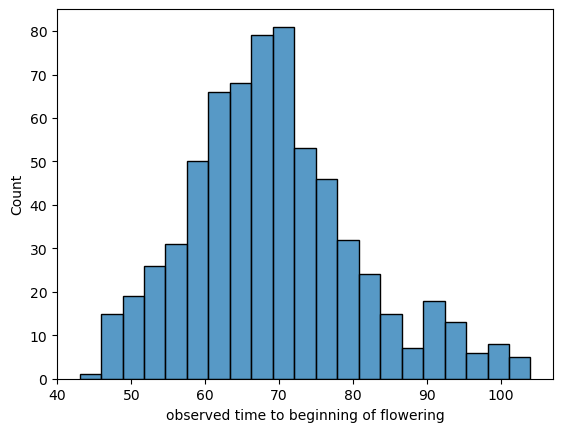

In [51]:
sns.histplot(ds_inputs_SSA['observed time to beginning of flowering'])

In [10]:
#ds_SSA_early = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'EPOP')|(ds_inputs_SSA['vargroup'] == 'EIHY')].groupby(['Stations_id', 'Referenzjahr', 'Management']).first().reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
ds_SSA_early = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'EPOP')|(ds_inputs_SSA['vargroup'] == 'EIHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
#ds_SSA_early = ds_SSA_early.loc[(ds_SSA_early['Management'] == 'Optimal')|(ds_SSA_early['Management'] == 'Low pH')|(ds_SSA_early['Management'] == 'Low N')].groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
#ds_SSA_early = ds_SSA_early.groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
early_ds_dict = split_ds_by_AEZ5(ds_SSA_early)


num semiarid low: 120 
num arid high: 59 
num humid low: 26 
num subhumid low: 67 
num subhumid high: 45


In [11]:
#ds_SSA_late = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'ILPO')|(ds_inputs_SSA['vargroup'] == 'ILHY')].groupby(['Stations_id', 'year', 'Management']).first().reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
ds_SSA_late = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'ILPO')|(ds_inputs_SSA['vargroup'] == 'ILHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
#ds_SSA_late = ds_SSA_late.loc[(ds_SSA_late['Management'] == 'Optimal')|(ds_SSA_late['Management'] == 'Low pH')|(ds_SSA_late['Management'] == 'Low N')].groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
late_ds_dict = split_ds_by_AEZ5(ds_SSA_late)


num semiarid low: 101 
num arid high: 50 
num humid low: 17 
num subhumid low: 68 
num subhumid high: 46


In [12]:
def SSA_plot(fig, ax):
#    fig,ax=plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines(resolution='10m')
    ax.set_extent([0, 50, -40, 20], ccrs.PlateCarree())
    ax.add_feature(cf.BORDERS, zorder = 0)
    return fig, ax

In [26]:
def Germany_plot(fig, ax):
    adm1_shapes = list(shpreader.Reader('gadm41_DEU_1/gadm41_DEU_1.shp').geometries())
    ax.coastlines(resolution='10m')
    ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor='black', facecolor='none', alpha=1)
    ax.set_extent([5, 16, 47, 56], ccrs.PlateCarree())
    return fig, ax

0
1
2
3
4


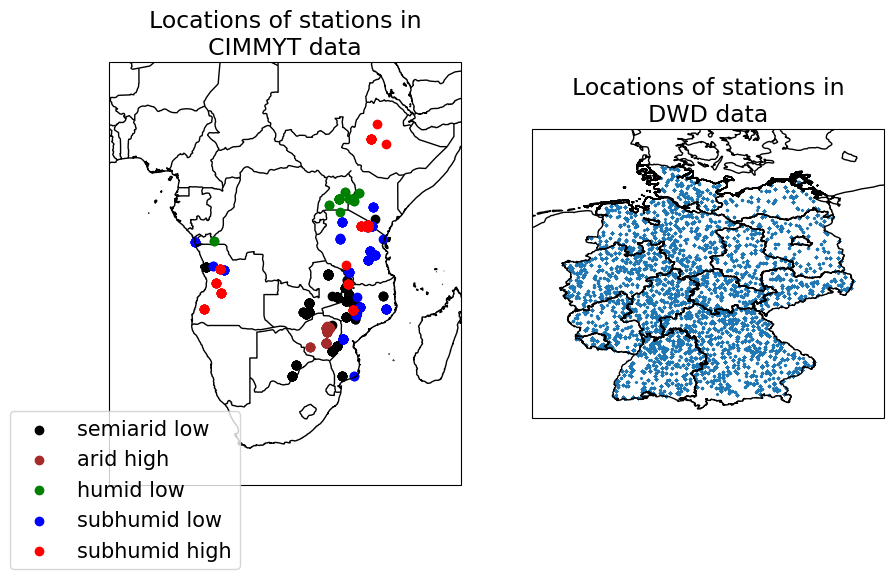

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10,20), subplot_kw={'projection': ccrs.PlateCarree()})
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}
fig, ax = SSA_plot(fig, axs[0])
for i, ds in enumerate(combined_variety_tests_dict.values()):
    print(i)
    ax.scatter(ds['lon'], ds['lat'], color = ['black', 'brown', 'green', 'blue', 'red'][i], label = ['semiarid low', 'arid high', 'humid low', 'subhumid low', 'subhumid high'][i])
ax.legend(bbox_to_anchor=[0.4, 0.2], fontsize = 15)
ax.set_title('Locations of stations in\nCIMMYT data', fontsize = 17)
fig, ax = Germany_plot(fig, axs[1])
ax.scatter(ds_inputs_DE['lon'], ds_inputs_DE['lat'], marker = 'x', s = 2)
ax.set_title('Locations of stations in\nDWD data', fontsize = 17)
fig.savefig('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\plots\\station_locations.png')

In [20]:
combined_variety_tests_dict.keys()

dict_keys(['arid low', 'city', 'arid high', 'humid low', 'humid high'])

In [82]:
no_regions_dict = {'early full': ds_SSA_early,
                   'late full': ds_SSA_late}
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}
no_regions_test = K_fold_transfer_regions(no_regions_dict, transfer_method='wang and first', index_cols=['Stations_id', 'year'])#'all wang')
results_combined_test = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='wang and first', index_cols=['Stations_id', 'year'])#'all wang')

early full [0.7016814947128296, 0.7061874866485596, 0.6861416697502136, 0.23992270231246948, 0.6874768137931824]
late full [0.7254036664962769, 0.6005967855453491, 0.6531519889831543, 0.5474591255187988, 0.6339661478996277]
semiarid low [0.6330983638763428, 0.8541276454925537, 0.7606961131095886, 0.7917231321334839, 0.2076926827430725]
arid high [0.09921020269393921, 0.07623177766799927, -0.09440124034881592, -0.26323091983795166, -0.03760218620300293]
humid low [-0.7454981803894043, 0.4641544222831726, 0.5986509323120117, 0.3926553726196289, 0.10200250148773193]
subhumid low [0.47220730781555176, -0.43272721767425537, 0.20943397283554077, 0.7330818176269531, 0.3053162693977356]
humid high [-0.0073882341384887695, -0.7260274887084961, -1.5326685905456543, -0.41302335262298584, -0.3320295810699463]


In [83]:
for ind, score_dict in enumerate([results_combined_test]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar, df_novar_pooled, df_novar_full = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_full['region'] = 'all combined'
#df_noreg, df_noreg_pooled, ___ = make_df_from_score_dict(no_regions_test_indomain)
df_novar_pooled = pd.concat([df_novar_full, df_novar_pooled])
df_novar_pooled['Model'] = 'Wageningen'
df_novar_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_pooled_score_Wageningen.csv')

In [84]:
df_noreg, df_noreg_pooled, ___ = make_df_from_score_dict(no_regions_test)
df_noreg_pooled['Variety'] = ['Early', 'Late']
df_noreg_pooled['Model'] = 'Wageningen'
df_noreg_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_regions_pooled_score_Wageningen.csv')

In [21]:
for i, comp_frame in enumerate(results_combined_test['comparison_frames']):
    print(results_combined_test['regions'][i],
          r2_score(comp_frame['observed'], comp_frame['fitted']),
          r2_score(comp_frame['observed'], comp_frame['GDD fitted']))

arid low 0.6802372932434082 0.44369959831237793
arid high -0.03081047534942627 -2.448406934738159
humid low 0.5388224720954895 -0.34651923179626465
humid high 0.2614949941635132 -0.41631245613098145


In [ ]:
df, df_pooled, df_full_model = make_df_from_score_dict(results_combined_test_first, TL_method='GDD', variety='combined')

In [ ]:
df_pooled

,R2 score,Variety,TL method
0,0.541327,combined,GDD
1,0.302497,combined,GDD
2,0.188403,combined,GDD
3,0.345718,combined,GDD


In [76]:
#results_dict_early_justrate = K_fold_transfer_regions(early_ds_dict, transfer_method='just rate')
results_dict_early = K_fold_transfer_regions(early_ds_dict, transfer_method='wang and first', index_cols = ['Stations_id', 'year'])#'all wang')
#results_dict_late_justrate = K_fold_transfer_regions(late_ds_dict, transfer_method='just rate')
results_dict_late = K_fold_transfer_regions(late_ds_dict, transfer_method='wang and first', index_cols = ['Stations_id', 'year'])#'all wang')

semiarid low [0.8603342771530151, 0.7918704748153687, 0.859680712223053, 0.793588399887085, -0.7212163209915161]
arid high [-0.3394348621368408, -0.15330016613006592, 0.1498185396194458, -0.27210891246795654, 0.029115378856658936]
humid low [0.317307710647583, 0.6788990497589111, 0.21052628755569458, -0.6714696884155273, -0.21710515022277832]
subhumid low [0.36384469270706177, 0.6026214957237244, 0.7067546844482422, 0.26644641160964966, 0.5679405927658081]
humid high [-0.02605283260345459, 0.1827353835105896, -0.40145230293273926, 0.1151418685913086, -0.7909090518951416]
semiarid low [0.8467012643814087, 0.836681604385376, 0.8314898014068604, 0.6683913469314575, 0.4202396273612976]
arid high [0.004045724868774414, 0.5604395866394043, -0.904761791229248, 0.23954707384109497, -0.03535354137420654]


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


humid low [-7.282828330993652, -0.6287877559661865, -0.08000004291534424, -50.000003814697266, -1.0199999809265137]
subhumid low [0.5111773610115051, 0.4346121549606323, -0.32352936267852783, 0.4175046682357788, 0.768168032169342]
humid high [-0.054245710372924805, -1.052105188369751, -1.612903118133545, -0.858710765838623, -0.3233681917190552]


In [26]:
#results_dict_early_justrate = K_fold_transfer_regions(early_ds_dict, transfer_method='just rate')
results_dict_early_KG = K_fold_transfer_regions(early_ds_dict, transfer_method='all wang', index_cols = ['Stations_id'])#)'wang and first'
#results_dict_late_justrate = K_fold_transfer_regions(late_ds_dict, transfer_method='just rate')
results_dict_late_KG = K_fold_transfer_regions(late_ds_dict, transfer_method='all wang', index_cols = ['Stations_id'])#)

semiarid low [-0.07558584213256836, 0.3538035750389099, 0.5422236919403076, 0.9292633533477783, -0.1662883758544922]
arid high [0.03277397155761719, -0.09259259700775146, -12.982142448425293, -2.161961793899536, -0.7138643264770508]
humid low [-2.452380895614624, -12.925926208496094, -0.54296875, 0.625, -0.6351351737976074]
subhumid low [0.5601687431335449, 0.1783784031867981, 0.05572444200515747, 0.8040564060211182, -0.23207104206085205]
humid high [-0.6148909330368042, 0.332965612411499, 0.15612101554870605, -0.5493502616882324, -1.4814815521240234]
semiarid low [0.10974806547164917, 0.6664333939552307, -1.2617244720458984, 0.7334609031677246, -0.018329977989196777]
arid high [-1.9897494316101074, -0.1203911304473877, -0.7789335250854492, -0.7051281929016113, -1.0299439430236816]
subhumid low [0.2397150993347168, 0.6724138259887695, -2.7507615089416504, -0.8851145505905151, 0.3127235174179077]
humid high [-0.5202184915542603, 0.4124297499656677, -0.07286429405212402, -1.4000000953674

In [39]:
#results_dict_early_justrate = K_fold_transfer_regions(early_ds_dict, transfer_method='just rate')
results_dict_early_rate = K_fold_transfer_regions(early_ds_dict, transfer_method='just rate', index_cols = ['Stations_id'])#)'wang and first'
#results_dict_late_justrate = K_fold_transfer_regions(late_ds_dict, transfer_method='just rate')
results_dict_late_rate = K_fold_transfer_regions(late_ds_dict, transfer_method='just rate', index_cols = ['Stations_id'])#)

semiarid low [-0.3612881898880005, 0.20385468006134033, -0.029803752899169922, 0.3921968936920166, -2.578319787979126]
arid high [-0.02683103084564209, -0.09259259700775146, -5.4162092208862305, -1.5254089832305908, -0.28023600578308105]


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


humid low [-5.714285850524902, -16.037036895751953, -3.511719226837158, 0.0, -0.20270276069641113]
subhumid low [0.3239343762397766, -0.21621620655059814, 0.03546100854873657, 0.34943270683288574, -0.26297831535339355]
humid high [-0.643132209777832, -0.14565610885620117, -0.1368638277053833, -0.9975413084030151, -0.18518519401550293]
semiarid low [-0.2940516471862793, 0.36616450548171997, 0.3134050965309143, 0.14707493782043457, -5.561863899230957]
arid high [-1.0728929042816162, -0.12234640121459961, -1.4343302249908447, -0.7051281929016113, -0.8997213840484619]
subhumid low [-0.017114877700805664, -0.4784482717514038, -1.6954314708709717, -0.26351428031921387, -0.07307112216949463]
humid high [-0.6125681400299072, 0.09284770488739014, 0.08542722463607788, -2.7866666316986084, -3.2919273376464844]


In [ ]:
#results_dict_early_justrate = K_fold_transfer_regions(early_ds_dict, transfer_method='just rate')
results_dict_early = K_fold_transfer_regions(early_ds_dict, transfer_method='wang and first', index_cols = ['Stations_id'])#'all wang')
#results_dict_late_justrate = K_fold_transfer_regions(late_ds_dict, transfer_method='just rate')
results_dict_late = K_fold_transfer_regions(late_ds_dict, transfer_method='wang and first', index_cols = ['Stations_id'])#'all wang')

In [77]:
for ind, score_dict in enumerate([results_dict_early, results_dict_late]):#[results_dict_early_justrate, results_dict_early, results_dict_late_justrate, results_dict_late]):
    variety = ['early', 'late'][ind]
    TL_method = ['Wang and first layer', 'Wang and first layer'][ind]
    df, df_pooled, df_full_model = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df['region'] = np.array(score_dict['regions'])
    df_pooled['region'] = np.array(score_dict['regions'])
    df_full_model['region'] = 'all combined'
    df_full_model['TL method'] = TL_method
    df = pd.concat((df, df_full_model))
    df_pooled = pd.concat((df_pooled, df_full_model))
    if ind == 0:
        df_full = df
        df_pooled_full = df_pooled
    else:
        df_full = pd.concat([df_full, df])
        df_pooled_full = pd.concat([df_pooled_full, df_pooled])

In [80]:
df_pooled_full['TL method'] = TL_method
df_pooled_full

,R2 score,Variety,region,TL method
0,0.659951,early,semiarid low,Wang and first layer
1,0.034162,early,arid high,Wang and first layer
2,0.376317,early,humid low,Wang and first layer
3,0.563472,early,subhumid low,Wang and first layer
4,0.156103,early,humid high,Wang and first layer
0,0.470453,early,all combined,Wang and first layer
0,0.751357,late,semiarid low,Wang and first layer
1,0.180945,late,arid high,Wang and first layer
2,-0.383431,late,humid low,Wang and first layer
3,0.534597,late,subhumid low,Wang and first layer


In [81]:
df_pooled_full['Model'] = 'Wageningen'
df_pooled_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_pooled_score_Wageningen_new_split.csv')

In [38]:
def skill_score_all_reg(score_dict):
    SSE_all_reg = np.array(score_dict['SSEs'])
    obsvars_all_reg = np.nan_to_num(np.array(score_dict['observed variances']))
    length_all_reg = np.array(score_dict['fold lengths'])
    MSE_all_reg = SSE_all_reg.sum(axis=0)/length_all_reg.sum(axis = 0)
    R2_all_reg = 1 - (SSE_all_reg.sum(axis=0)/((length_all_reg - 1)*obsvars_all_reg).sum(axis=0))
    R2_all_reg_split = 1 - (SSE_all_reg/((length_all_reg - 1)*obsvars_all_reg))
    #R2_pooled = 1 - (SSE_all_reg.sum(axis=1)/((length_all_reg - 1)*obsvars_all_reg).sum(axis=1))
    R2_pooled = []
    for cf in score_dict['comparison_frames']:
        R2_pooled.append(r2_score(cf['observed'], cf['fitted']))
    R2_pooled = np.array(R2_pooled)
    return R2_all_reg, R2_all_reg_split, R2_pooled

def make_df_from_score_dict(score_dict, TL_method = 'NA', variety = 'NA'):
    R2s, R2s_split, R2s_pooled = skill_score_all_reg(score_dict)
    df = pd.DataFrame()
    df['R2 score'] = R2s_split.mean(axis=1)
    df_pooled = pd.DataFrame()
    df_pooled['R2 score'] = R2s_pooled
    df['Variety'] = variety
    df_pooled['Variety'] = variety
    df_full_model = pd.DataFrame()
    df_full_model['Variety'] = [variety]
    df_full_model['R2 score'] = [R2s.mean()]
    return df, df_pooled, df_full_model

In [56]:
score_dict = results_dict_late
SSE_all_reg = np.array(score_dict['SSEs'])
obsvars_all_reg = np.nan_to_num(np.array(score_dict['observed variances']))
length_all_reg = np.array(score_dict['fold lengths'])
MSE_all_reg = SSE_all_reg.sum(axis=0)/length_all_reg.sum(axis = 0)
R2_all_reg = 1 - (SSE_all_reg.sum()/((length_all_reg - 1)*obsvars_all_reg).sum())
R2_all_reg_split = 1 - (SSE_all_reg/((length_all_reg - 1)*obsvars_all_reg))
#R2_pooled = 1 - (SSE_all_reg.sum(axis=1)/((length_all_reg - 1)*obsvars_all_reg).sum(axis=1))
R2_pooled = []
for cf in score_dict['comparison_frames']:
    R2_pooled.append(r2_score(cf['observed'], cf['fitted']))

R2_pooled = np.array(R2_pooled)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_11100\3311247977.py:7: RuntimeWarning: divide by zero encountered in divide
  R2_all_reg_split = 1 - (SSE_all_reg/((length_all_reg - 1)*obsvars_all_reg))


In [57]:
results_dict_late['regions']

['semiarid low', 'arid high', 'humid low', 'subhumid low', 'humid high']

In [58]:
score_dict['comparison_frames'][2]

,fitted,observed,GDD fitted,Error
0,71.0,68.0,65.0,-3.0
1,71.0,68.0,65.0,-3.0
0,71.0,-88.0,66.0,-159.0
0,74.0,72.0,67.0,-2.0
1,73.0,72.0,67.0,-1.0
2,74.0,76.0,67.0,2.0
3,73.0,72.0,67.0,-1.0
0,70.0,78.0,64.0,8.0
1,70.0,68.0,64.0,-2.0
2,70.0,67.0,64.0,-3.0


In [44]:
((length_all_reg - 1)*obsvars_all_reg).sum(axis=0)

array([2836.13098526, 4514.13424969,  964.02637434, 7971.02780342,
       3176.96554947])

In [46]:
R2_all_reg

np.float64(-0.9500793495603066)

In [35]:
for ind, score_dict in enumerate([results_dict_late]):#results_dict_early, [results_dict_early_justrate, results_dict_early, results_dict_late_justrate, results_dict_late]):
    variety = ['late', 'late'][ind]
    TL_method = ['Wang and first layer', 'Wang and first layer'][ind]
    df, df_pooled, df_full_model = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df['region'] = np.array(score_dict['regions'])
    df_pooled['region'] = np.array(score_dict['regions'])
    df_full_model['region'] = 'all combined'
    df_full_model['TL method'] = TL_method
    df = pd.concat((df, df_full_model))
    df_pooled = pd.concat((df_pooled, df_full_model))
    if ind == 0:
        df_full = df
        df_pooled_full = df_pooled
    else:
        df_full = pd.concat([df_full, df])
        df_pooled_full = pd.concat([df_pooled_full, df_pooled])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_16768\1566368759.py:7: RuntimeWarning: divide by zero encountered in divide
  R2_all_reg_split = 1 - (SSE_all_reg/((length_all_reg - 1)*obsvars_all_reg))


In [36]:
df_pooled_full

,R2 score,Variety,region,TL method
0,0.687050,late,semiarid low,NaN
1,-1.330546,late,arid high,NaN
2,-0.056700,late,humid low,NaN
3,0.245524,late,subhumid low,NaN
4,0.134753,late,humid high,NaN
0,-0.893637,late,all combined,Wang and first layer


In [43]:
df_pooled_full2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_pooled_score_Wageningen_new_split.csv')
df_pooled_full['Model'] = 'Wageningen'
df_pooled_full2 = df_pooled_full2.loc[df_pooled_full2['Variety'] == 'early']
df_pooled_full2 = pd.concat([df_pooled_full, df_pooled_full2])

In [44]:
df_pooled_full2

,R2 score,Variety,region,TL method,Model,Unnamed: 0
0,0.687050,late,semiarid low,NaN,Wageningen,NaN
1,-1.330546,late,arid high,NaN,Wageningen,NaN
2,-0.056700,late,humid low,NaN,Wageningen,NaN
3,0.245524,late,subhumid low,NaN,Wageningen,NaN
4,0.134753,late,humid high,NaN,Wageningen,NaN
0,-0.893637,late,all combined,Wang and first layer,Wageningen,NaN
0,0.649747,early,semiarid low,Wang and first layer,Wageningen,0.0
1,-1.068444,early,arid high,Wang and first layer,Wageningen,1.0
2,0.282585,early,humid low,Wang and first layer,Wageningen,2.0
3,0.366619,early,subhumid low,Wang and first layer,Wageningen,3.0


In [45]:
df_pooled_full['Model'] = 'Wageningen'
df_pooled_full2.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_pooled_score_Wageningen_new_split.csv')

In [14]:
df_noreg, df_noreg_pooled, ___ = make_df_from_score_dict(no_regions_test)
df_noreg_pooled['Variety'] = ['Early', 'Late']
for ind, score_dict in enumerate([results_combined_test]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar, df_novar_pooled, ____ = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])

In [16]:
df_noreg_pooled

,R2 score,Variety,TL method
0,0.628517,Early,NA
1,0.648140,Late,NA


In [18]:
df_novar_pooled

,R2 score,Variety,TL method,region
0,0.680237,combined,first,arid low
1,-0.030810,combined,first,arid high
2,0.538822,combined,first,humid low
3,0.261495,combined,first,humid high


In [19]:
for ind, score_dict in enumerate([results_dict_early, results_dict_late]):#[results_dict_early_justrate, results_dict_early, results_dict_late_justrate, results_dict_late]):
    variety = ['early', 'early', 'late', 'late'][ind]
    TL_method = ['just rate', 'all Wang', 'just rate', 'all Wang'][ind]
    df, df_pooled, df_full_model = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df['region'] = np.array(score_dict['regions'])
    df_pooled['region'] = np.array(score_dict['regions'])
    df_full_model['region'] = 'all combined'
    df_full_model['TL method'] = TL_method
    df = pd.concat((df, df_full_model))
    df_pooled = pd.concat((df_pooled, df_full_model))
    if ind == 0:
        df_full = df
        df_pooled_full = df_pooled
    else:
        df_full = pd.concat([df_full, df])
        df_pooled_full = pd.concat([df_pooled_full, df_pooled])


In [20]:
df_pooled_full

,R2 score,Variety,TL method,region
0,0.660290,early,just rate,arid low
1,-0.005169,early,just rate,arid high
2,0.562104,early,just rate,humid low
3,0.245931,early,just rate,humid high
0,0.552313,early,just rate,all combined
0,0.788797,early,all Wang,arid low
1,-0.170049,early,all Wang,arid high
2,0.478290,early,all Wang,humid low
3,0.117657,early,all Wang,humid high
0,0.552640,early,all Wang,all combined


In [ ]:
df_full

,R2 score,Variety,TL method,region
0,0.338745,early,just rate,arid low
1,-2.132096,early,just rate,city
2,-0.059906,early,just rate,high
3,0.131749,early,just rate,humid low
0,0.118099,early,just rate,all combined
0,0.572409,early,all Wang,arid low
1,0.061416,early,all Wang,city
2,-0.016361,early,all Wang,high
3,0.398828,early,all Wang,humid low
0,0.446160,early,all Wang,all combined


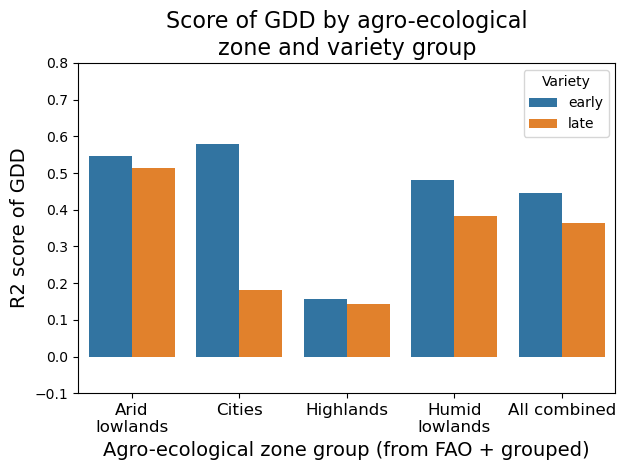

In [ ]:
font_size = 14
fig, ax = plt.subplots()
sns.barplot(data = df_pooled_full.loc[df_pooled_full['TL method'] == 'all Wang'], hue = 'Variety', x = 'region', y='R2 score', ax=ax)
ax.set_xticks(range(5), ['Arid\nlowlands', 'Cities', 'Highlands', 'Humid\nlowlands', 'All combined'], fontsize =font_size - 2)
ax.set_ylabel('R2 score of GDD', fontsize =font_size)
ax.set_xlabel('Agro-ecological zone group (from FAO + grouped)', fontsize =font_size)
ax.set_title('Score of GDD by agro-ecological\nzone and variety group', fontsize = font_size +2)
ax.set_ylim((-0.1, 0.8))
fig.tight_layout()

In [39]:
#train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
bs = 30000
n_channels = 5
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #photoperiod_series_DE,
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)[2022, 2023, 2024]
#train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.8)
#train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2023, 2024], year_column = -2, bs = bs, n_channels = n_channels, train_proportion=0.8)
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16#day2 -> 8#day -> 16 #day3 ->4
num_layers = 4#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False
KG2 = True
CNN = False
bce=True

model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, KG2)
save_name = 'NN_response_DE_no_day5_more_epochs'

epochs = 500
lr=0.01
#run K-fold cross validation
criterion = problist_square_loss()
comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_transfer(5, combined_variety_tests_dict['semiarid low'], nn_temp_response, 
                                                                                                        save_name, epochs, bs, model_args, lr = lr, savename_prefix='semiarid_resp_TL',
                                                                                                        loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                        custom_loss=criterion, DTF = False, transfer_method = 'wang and first',
                                                                                                        verbose=True, index_cols=['Stations_id'])

0 101.47637176513672 112.90184783935547
1 96.3720932006836 102.31913757324219
2 91.35459899902344 92.15660858154297
48 36.81172561645508 32.49589157104492
49 36.571346282958984 32.307735443115234
50 36.33940505981445 32.298702239990234
51 36.11402130126953 32.535953521728516
52 35.88191223144531 32.941192626953125
98 30.13240623474121 32.92206573486328
99 30.05329132080078 32.960933685302734
100 29.975046157836914 33.01150131225586
101 29.897890090942383 33.046844482421875
102 29.821805953979492 33.05467987060547
148 27.111940383911133 33.73762512207031
149 27.06419563293457 33.7484016418457
150 27.016803741455078 33.75984191894531
151 26.96976661682129 33.77324676513672
152 26.923095703125 33.78798294067383
198 25.08598518371582 34.23506164550781
199 25.055187225341797 34.241119384765625
200 25.02483367919922 34.246829986572266
201 24.994953155517578 34.252418518066406
202 24.965505599975586 34.25801086425781
248 23.93887710571289 34.633209228515625
249 23.921772003173828 34.642894744

In [64]:
comparison_frame

,fitted,observed,GDD fitted,Error
0,74.0,68.0,73.0,-6.0
1,74.0,68.0,73.0,-6.0
0,74.0,-88.0,73.0,-162.0
0,75.0,72.0,73.0,-3.0
1,75.0,72.0,73.0,-3.0
2,76.0,76.0,74.0,0.0
3,75.0,72.0,73.0,-3.0
0,75.0,67.0,74.0,-8.0
1,74.0,64.0,72.0,-10.0
2,75.0,72.0,74.0,-3.0


In [62]:
R2s

[-1.25,
 -0.6058393716812134,
 -0.5535714626312256,
 -2.843750238418579,
 -0.15979373455047607]

In [38]:
r2_score(comparison_frame['observed'], comparison_frame['fitted'])

0.1936587691307068

In [33]:
R2s

[0.8179190754890442,
 -0.4984227418899536,
 0.7176591157913208,
 0.3643263578414917,
 0.8127753734588623]

In [ ]:
np.mean(np.array(R2s))

np.float64(0.5425811648368836)

In [ ]:
r2_score(comparison_frame['observed'], comparison_frame['fitted'])

0.5504122972488403

In [ ]:
r2_score(comparison_frame['observed'], comparison_frame['fitted'])

0.27426183223724365